## load the dataset that was generated for Donut

In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("/home/sebastian/Documents/Hauptprojekt/Daten_Donut_all_classes")

Resolving data files:   0%|          | 0/10390 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/251 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3755 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 10389
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 250
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 3754
    })
})

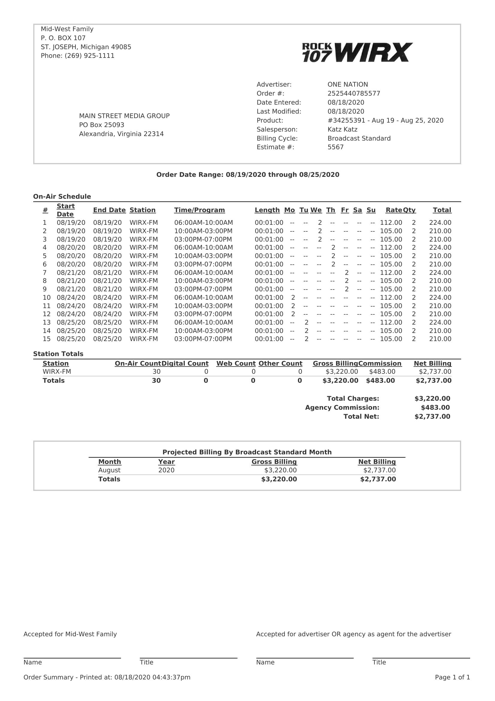

In [4]:
example = dataset['train'][0]
image = example['image']
# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.3), int(height*0.3))))

check the ground truth for the image. Just a test to see if it dispalys as expected

In [5]:
# let's load the corresponding JSON dictionary (as string representation)
ground_truth = example['ground_truth']
print(ground_truth)

{"gt_parse": {"field_extractions": [{"fieldtype": "document_id", "text": "2525440785577"}, {"fieldtype": "date_issue", "text": "2020-08-18"}, {"fieldtype": "vendor_name", "text": "Mid-West Family"}, {"fieldtype": "vendor_address", "text": "Mid-West Family\nP. O. BOX 107\nST. JOSEPH, Michigan 49085"}, {"fieldtype": "customer_billing_name", "text": "MAIN STREET MEDIA GROUP"}, {"fieldtype": "customer_billing_address", "text": "MAIN STREET MEDIA GROUP\nPO Box 25093\nAlexandria, Virginia 22314"}, {"fieldtype": "currency_code_amount_due", "text": "$"}, {"fieldtype": "amount_total_gross", "text": "$3,220.00"}, {"fieldtype": "amount_total_gross", "text": "$3,220.00"}, {"fieldtype": "amount_total_gross", "text": "$3,220.00"}, {"fieldtype": "amount_due", "text": "$2,737.00"}, {"fieldtype": "amount_due", "text": "$2,737.00"}, {"fieldtype": "amount_due", "text": "$2,737.00"}], "line_item_extractions": [{"fieldtype": "line_item_position", "line_item_id": 1, "text": "1"}, {"fieldtype": "line_item_da

In [6]:
from ast import literal_eval

literal_eval(ground_truth)['gt_parse']

{'field_extractions': [{'fieldtype': 'document_id', 'text': '2525440785577'},
  {'fieldtype': 'date_issue', 'text': '2020-08-18'},
  {'fieldtype': 'vendor_name', 'text': 'Mid-West Family'},
  {'fieldtype': 'vendor_address',
   'text': 'Mid-West Family\nP. O. BOX 107\nST. JOSEPH, Michigan 49085'},
  {'fieldtype': 'customer_billing_name', 'text': 'MAIN STREET MEDIA GROUP'},
  {'fieldtype': 'customer_billing_address',
   'text': 'MAIN STREET MEDIA GROUP\nPO Box 25093\nAlexandria, Virginia 22314'},
  {'fieldtype': 'currency_code_amount_due', 'text': '$'},
  {'fieldtype': 'amount_total_gross', 'text': '$3,220.00'},
  {'fieldtype': 'amount_total_gross', 'text': '$3,220.00'},
  {'fieldtype': 'amount_total_gross', 'text': '$3,220.00'},
  {'fieldtype': 'amount_due', 'text': '$2,737.00'},
  {'fieldtype': 'amount_due', 'text': '$2,737.00'},
  {'fieldtype': 'amount_due', 'text': '$2,737.00'}],
 'line_item_extractions': [{'fieldtype': 'line_item_position',
   'line_item_id': 1,
   'text': '1'},
  {

## prepare Model for training

In [7]:
from transformers import VisionEncoderDecoderConfig

image_size = [1280, 960]
max_length = 768

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length

In [8]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base", config=config)

2023-10-24 13:02:40.878609: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-24 13:02:40.912551: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 13:02:41.464448: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [9]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

added_tokens = []

class DonutDataset(Dataset):
    """
    PyTorch Dataset for Donut. This class takes a HuggingFace Dataset as input.
    
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into pixel_values (vectorized image) and labels (input_ids of the tokenized string).
    
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)
    
    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # inputs
        pixel_values = processor(sample["image"], random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # targets
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        return pixel_values, labels, target_sequence

set train and val dataset

In [10]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.image_processor.size = image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False

train_dataset = DonutDataset("/home/sebastian/Documents/Hauptprojekt/Daten_Donut_all_classes", max_length=max_length,
                             split="train", task_start_token="<s_docile>", prompt_end_token="<s_docile>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

val_dataset = DonutDataset("/home/sebastian/Documents/Hauptprojekt/Daten_Donut_all_classes", max_length=max_length,
                             split="validation", task_start_token="<s_docile>", prompt_end_token="<s_docile>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

Resolving data files:   0%|          | 0/10390 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/251 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3755 [00:00<?, ?it/s]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 57527. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 57529. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means th

Resolving data files:   0%|          | 0/10390 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/251 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3755 [00:00<?, ?it/s]

see how many custom tokens were added

In [11]:
len(added_tokens)

14

In [12]:
print(added_tokens)

['<s_field_extractions>', '</s_field_extractions>', '<s_fieldtype>', '</s_fieldtype>', '<s_text>', '</s_text>', '<s_line_item_extractions>', '</s_line_item_extractions>', '<s_line_item_id>', '</s_line_item_id>', '<s_line_item_headers>', '</s_line_item_headers>', '<s_docile>', '<s_docile>']


In [13]:
print("Original number of tokens:", processor.tokenizer.vocab_size)
print("Number of tokens after adding special tokens:", len(processor.tokenizer))

Original number of tokens: 57522
Number of tokens after adding special tokens: 57538


In [14]:
processor.decode([57530])

'</s_text>'

get torch Size

In [15]:
pixel_values, labels, target_sequence = train_dataset[0]

In [16]:
print(pixel_values.shape)

torch.Size([3, 1280, 960])


look at an decoded example to test if it displays as expected

In [17]:
# let's print the labels (the first 30 token ID's)
for id in labels.tolist()[:30]:
    if id != -100:
        print(processor.decode([id]))
    else:
        print(id)

<s_field_extractions>
<s_fieldtype>
document
_
id
</s_fieldtype>
<s_text>
25
25
4
40
785
5
77
</s_text>
<sep/>
<s_fieldtype>
date
_
is
su
e
</s_fieldtype>
<s_text>
2020
-08
-18
</s_text>
<sep/>
<s_fieldtype>


In [18]:
print(target_sequence)

<s_field_extractions><s_fieldtype>document_id</s_fieldtype><s_text>2525440785577</s_text><sep/><s_fieldtype>date_issue</s_fieldtype><s_text>2020-08-18</s_text><sep/><s_fieldtype>vendor_name</s_fieldtype><s_text>Mid-West Family</s_text><sep/><s_fieldtype>vendor_address</s_fieldtype><s_text>Mid-West Family
P. O. BOX 107
ST. JOSEPH, Michigan 49085</s_text><sep/><s_fieldtype>customer_billing_name</s_fieldtype><s_text>MAIN STREET MEDIA GROUP</s_text><sep/><s_fieldtype>customer_billing_address</s_fieldtype><s_text>MAIN STREET MEDIA GROUP
PO Box 25093
Alexandria, Virginia 22314</s_text><sep/><s_fieldtype>currency_code_amount_due</s_fieldtype><s_text>$</s_text><sep/><s_fieldtype>amount_total_gross</s_fieldtype><s_text>$3,220.00</s_text><sep/><s_fieldtype>amount_total_gross</s_fieldtype><s_text>$3,220.00</s_text><sep/><s_fieldtype>amount_total_gross</s_fieldtype><s_text>$3,220.00</s_text><sep/><s_fieldtype>amount_due</s_fieldtype><s_text>$2,737.00</s_text><sep/><s_fieldtype>amount_due</s_fieldt

In [19]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_docile>'])[0]

In [20]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_docile>


## create Dataloader

In [21]:
from torch.utils.data import DataLoader

# feel free to increase the batch size if you have a lot of memory
# I'm fine-tuning on Colab and given the large image size, batch size > 1 is not feasible
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [22]:
batch = next(iter(train_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [23]:
for id in labels.squeeze().tolist():
    if id != -100:
        print(processor.decode([id]))
    else:
        print(id)

<s_field_extractions>
<s_fieldtype>
customer
_
bil
ling
_
name
</s_fieldtype>
<s_text>
Dan
nie
Lot
t
</s_text>
<sep/>
<s_fieldtype>
vend
or
_
name
</s_fieldtype>
<s_text>
Del
mar
Con
ley
</s_text>
<sep/>
<s_fieldtype>
amount
_
to
tal
_
gros
s
</s_fieldtype>
<s_text>
5
29
.
4
</s_text>
<sep/>
<s_fieldtype>
payment
_
term
s
</s_fieldtype>
<s_text>
due
for
the
first
2
qua
ters
April
1
,
2001
-
September
30
,
2001
</s_text>
<sep/>
<s_fieldtype>
date
_
is
su
e
</s_fieldtype>
<s_text>
01
/18
/20
22
</s_text>
<sep/>
<s_fieldtype>
amount
_
du
e
</s_fieldtype>
<s_text>
5
29
.
4
</s_text>
<sep/>
<s_fieldtype>
vend
or
_
ad
dre
s
s
</s_fieldtype>
<s_text>
Del
mar
Con
ley
9
27
Lo
well
Lo
dge
99
45
2
,
Den
ton
Massa
chu
sett
s
United
States
</s_text>
<sep/>
<s_fieldtype>
vend
or
_
ad
dre
s
s
</s_fieldtype>
<s_text>
137
Dor
man
Ran
ch
850
79
,
Colli
ns
ville
United
States
</s_text>
<sep/>
<s_fieldtype>
document
_
id
</s_fieldtype>
<s_text>
9
</s_text>
<sep/>
<s_fieldtype>
customer
_
bil
ling
_
ad
dre

In [24]:
# let's check the first validation batch
batch = next(iter(val_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [25]:
from pathlib import Path
import re
from nltk import edit_distance
import numpy as np
import math

from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only


class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        pixel_values, labels, _ = batch
        
        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, labels, answers = batch
        batch_size = pixel_values.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full((batch_size, 1), self.model.config.decoder_start_token_id, device=self.device)
        
        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_input_ids,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)
    
        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            # NOT NEEDED ANYMORE
            # answer = re.sub(r"<.*?>", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                #print(f"Prediction: {pred}")
                #print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))
        
        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))
    
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

## Train Model

In [26]:
epochs = 10
config = {"max_epochs":epochs,
          "check_val_every_n_epoch":1,
          "gradient_clip_val":1.0,
          "num_training_samples_per_epoch": 10389,
          "lr":1e-5,
          "train_batch_sizes": [8],
          "val_batch_sizes": [1],
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 225, # 800/8*30/10, 10%
          "result_path": "./result",
          "verbose": True,
          }

model_module = DonutModelPLModule(config, processor, model)

In [27]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, EarlyStopping

wandb_logger = WandbLogger(project="Donut", name="Docile10epochs_10389train_250val_all_classes")

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub("ZaNioxX/Donut_infoext_" + str(trainer.current_epoch) + "epochs_all_classes",
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")            

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub("ZaNioxX/Donut_infoext_10epochs_all_classes",
                                    commit_message=f"Training done")
        pl_module.model.push_to_hub("ZaNioxX/Donut_infoext_10epochs_all_classes",
                                    commit_message=f"Training done")

early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=8, verbose=False, mode="min")

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision=16, # we'll use mixed precision
        num_sanity_val_steps=0,
        logger=wandb_logger,
        callbacks=[PushToHubCallback(), early_stop_callback],
)

trainer.fit(model_module)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: sebastian-strobel. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/lightning_fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | VisionEncoderDecoderModel | 201 M 
------

Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/utils.py:1411: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.3333333333333333


/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


 Normed ED: 0.274210713018801
 Normed ED: 0.4435946462715105
 Normed ED: 0.5112299465240642
 Normed ED: 0.4499492974069245
 Normed ED: 0.21682195920423067
 Normed ED: 0.46212896622313204
 Normed ED: 0.2537866038370919
 Normed ED: 0.539308176100629
 Normed ED: 0.8037028245905531
 Normed ED: 0.35608365019011406
 Normed ED: 0.37700706486833657
 Normed ED: 0.24363932424180745
 Normed ED: 0.3601871101871102
 Normed ED: 0.2482794218857536
 Normed ED: 0.3768882175226586
 Normed ED: 0.36319444444444443
 Normed ED: 0.1656686626746507
 Normed ED: 0.10731194108364019
 Normed ED: 0.21011673151750973
 Normed ED: 0.4317531021317213
 Normed ED: 0.8046525649399588
 Normed ED: 0.4380460683081811
 Normed ED: 0.10159151193633953
 Normed ED: 0.5807766990291262
 Normed ED: 0.18065153010858837
 Normed ED: 0.5240143369175627
 Normed ED: 0.6214995483288166
 Normed ED: 0.6300124018189335
 Normed ED: 0.5118110236220472
 Normed ED: 0.5322618215699977
 Normed ED: 0.7194259567387687
 Normed ED: 0.09031281533804238

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.20903954802259886
 Normed ED: 0.4135514018691589
 Normed ED: 0.027724665391969407
 Normed ED: 0.01020408163265306
 Normed ED: 0.4321309575546864
 Normed ED: 0.1734047735021919
 Normed ED: 0.43312101910828027
 Normed ED: 0.27364523729384044
 Normed ED: 0.2387697288547147
 Normed ED: 0.7770386794777039
 Normed ED: 0.8667300380228137
 Normed ED: 0.29627207325049054
 Normed ED: 0.6269082027274577
 Normed ED: 0.32031662269129285
 Normed ED: 0.231417756366139
 Normed ED: 0.0037764350453172208
 Normed ED: 0.3552777777777778
 Normed ED: 0.022288755821689953
 Normed ED: 0.016307206733298264
 Normed ED: 0.15992217898832684
 Normed ED: 0.40232262169901367
 Normed ED: 0.8009847761643973
 Normed ED: 0.4171299973523961
 Normed ED: 0.002122015915119363
 Normed ED: 0.5703883495145631
 Normed ED: 0.03257650542941757
 Normed ED: 0.37114337568058076
 Normed ED: 0.5838758137205808
 Normed ED: 0.09971777986829727
 Normed ED: 0.12866603595080417
 Normed ED: 0.5096668996040066
 Normed ED: 0.724

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.5772128060263654
 Normed ED: 0.936147570060305
 Normed ED: 0.0124282982791587
 Normed ED: 0.14209591474245115
 Normed ED: 0.42952339562509056
 Normed ED: 0.11281792999244523
 Normed ED: 0.4809116809116809
 Normed ED: 0.26657691013126894
 Normed ED: 0.2947103274559194
 Normed ED: 0.7593264248704663
 Normed ED: 0.3209125475285171
 Normed ED: 0.466403162055336
 Normed ED: 0.22409932831263993
 Normed ED: 0.3201685097419695
 Normed ED: 0.22883688919476944
 Normed ED: 0.10649546827794562
 Normed ED: 0.3522222222222222
 Normed ED: 0.000998003992015968
 Normed ED: 0.01209889531825355
 Normed ED: 0.004667444574095682
 Normed ED: 0.43207126948775054
 Normed ED: 0.79791991157112
 Normed ED: 0.41646809637278265
 Normed ED: 0.002122015915119363
 Normed ED: 0.573495145631068
 Normed ED: 0.03981572885817703
 Normed ED: 0.008563273073263558
 Normed ED: 0.011204481792717087
 Normed ED: 0.008466603951081843
 Normed ED: 0.014191106906338695
 Normed ED: 0.5112974609829956
 Normed ED: 0.70812

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.2565913370998117
 Normed ED: 0.30117062788222776
 Normed ED: 0.014340344168260038
 Normed ED: 0.14209591474245115
 Normed ED: 0.44473417354773287
 Normed ED: 0.0861244019138756
 Normed ED: 0.4271276595744681
 Normed ED: 0.26994278020868395
 Normed ED: 0.08377175232699312
 Normed ED: 0.4694915254237288
 Normed ED: 0.2743346007604563
 Normed ED: 0.28836633663366334
 Normed ED: 0.21331162222674538
 Normed ED: 0.16331658291457288
 Normed ED: 0.2339986235375086
 Normed ED: 0.0037764350453172208
 Normed ED: 0.35375
 Normed ED: 0.0006653359946773121
 Normed ED: 0.012092534174553101
 Normed ED: 0.002723735408560311
 Normed ED: 0.3587336939230035
 Normed ED: 0.7963623574335528
 Normed ED: 0.4166004765687053
 Normed ED: 0.1493368700265252
 Normed ED: 0.5738834951456311
 Normed ED: 0.0026324448831852583
 Normed ED: 0.008563273073263558
 Normed ED: 0.008403361344537815
 Normed ED: 0.008466603951081843
 Normed ED: 0.01229895931882687
 Normed ED: 0.5089680875844398
 Normed ED: 0.713325

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.8177966101694916
 Normed ED: 0.30688580334372345
 Normed ED: 0.0057361376673040155
 Normed ED: 0.1354723707664884
 Normed ED: 0.44212661161813704
 Normed ED: 0.13517441860465115
 Normed ED: 0.3492537313432836
 Normed ED: 0.2682598451699764
 Normed ED: 0.1068556108770586
 Normed ED: 0.5530227948463825
 Normed ED: 0.2798479087452472
 Normed ED: 0.2740447957839262
 Normed ED: 0.30836556075717486
 Normed ED: 0.1318032786885246
 Normed ED: 0.22814865794907088
 Normed ED: 0.0037764350453172208
 Normed ED: 0.35041666666666665
 Normed ED: 0.00033266799733865603
 Normed ED: 0.003156233561283535
 Normed ED: 0.0031116297160637884
 Normed ED: 0.3623926185173401
 Normed ED: 0.7958599206149827
 Normed ED: 0.414614773629865
 Normed ED: 0.03262599469496021
 Normed ED: 0.5741747572815534
 Normed ED: 0.0019743336623889436
 Normed ED: 0.008563273073263558
 Normed ED: 0.008403361344537815
 Normed ED: 0.008466603951081843
 Normed ED: 0.00945179584120983
 Normed ED: 0.5121127416724901
 Normed 

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the enviro

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.14245416078984485
 Normed ED: 0.4122029088329195
 Normed ED: 0.0057361376673040155
 Normed ED: 0.14209591474245115
 Normed ED: 0.4180790960451977
 Normed ED: 0.1824561403508772
 Normed ED: 0.4032165422171166
 Normed ED: 0.2689330191854594
 Normed ED: 0.08984216916228248
 Normed ED: 0.13822688274547187
 Normed ED: 0.3011406844106464
 Normed ED: 0.22661396574440051
 Normed ED: 0.1681253816405455
 Normed ED: 0.09477611940298507
 Normed ED: 0.22918100481761872
 Normed ED: 0.004528301886792453
 Normed ED: 0.3506944444444444
 Normed ED: 0.00033266799733865603
 Normed ED: 0.003156233561283535
 Normed ED: 0.002723735408560311
 Normed ED: 0.3620744511613109
 Normed ED: 0.7970155252976938
 Normed ED: 0.4152766746094784
 Normed ED: 0.0005303632988597189
 Normed ED: 0.5737864077669903
 Normed ED: 0.0029585798816568047
 Normed ED: 0.008563273073263558
 Normed ED: 0.01027077497665733
 Normed ED: 0.008466603951081843
 Normed ED: 0.00945179584120983
 Normed ED: 0.508851618914512
 Normed 

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the enviro

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.10546139359698682
 Normed ED: 0.23767293366442
 Normed ED: 0.1711281070745698
 Normed ED: 0.1423487544483986
 Normed ED: 0.4389395914819644
 Normed ED: 0.12564342536265793
 Normed ED: 0.22727272727272727
 Normed ED: 0.27128912823964996
 Normed ED: 0.16653726708074534
 Normed ED: 0.730261454827854
 Normed ED: 0.29524714828897336
 Normed ED: 0.3451910408432148
 Normed ED: 0.17504579686545899
 Normed ED: 0.1203155818540434
 Normed ED: 0.22763248451479698
 Normed ED: 0.0037764350453172208
 Normed ED: 0.35180555555555554
 Normed ED: 0.0006653359946773121
 Normed ED: 0.004203888596952181
 Normed ED: 0.002723735408560311
 Normed ED: 0.3647788736875597
 Normed ED: 0.7973672310706929
 Normed ED: 0.420174741858618
 Normed ED: 0.0005303632988597189
 Normed ED: 0.5737864077669903
 Normed ED: 0.006910167818361303
 Normed ED: 0.008563273073263558
 Normed ED: 0.008403361344537815
 Normed ED: 0.008466603951081843
 Normed ED: 0.00945179584120983
 Normed ED: 0.5122292103424179
 Normed ED: 

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.23728813559322035
 Normed ED: 0.36857041504079463
 Normed ED: 0.014340344168260038
 Normed ED: 0.1354723707664884
 Normed ED: 0.41576126321889034
 Normed ED: 0.09878600333253987
 Normed ED: 0.4072249589490969
 Normed ED: 0.2445304611242006
 Normed ED: 0.12585997571833266
 Normed ED: 0.5639412997903563
 Normed ED: 0.26958174904942966
 Normed ED: 0.07480073574494175
 Normed ED: 0.2312232851618156
 Normed ED: 0.09850746268656717
 Normed ED: 0.22797660013764626
 Normed ED: 0.0037764350453172208
 Normed ED: 0.35083333333333333
 Normed ED: 0.00033266799733865603
 Normed ED: 0.003156233561283535
 Normed ED: 0.0031128404669260703
 Normed ED: 0.36955138402799875
 Normed ED: 0.798171129980405
 Normed ED: 0.41474715382578764
 Normed ED: 0.0005303632988597189
 Normed ED: 0.5737864077669903
 Normed ED: 0.0019743336623889436
 Normed ED: 0.008563273073263558
 Normed ED: 0.008403361344537815
 Normed ED: 0.008466603951081843
 Normed ED: 0.008514664143803218
 Normed ED: 0.5156068017703238


pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.1596045197740113
 Normed ED: 0.3511883646683221
 Normed ED: 0.032504780114722756
 Normed ED: 0.1354723707664884
 Normed ED: 0.4521222656815877
 Normed ED: 0.10408307764928015
 Normed ED: 0.3542094455852156
 Normed ED: 0.27415011780545273
 Normed ED: 0.22577580747308423
 Normed ED: 0.13157894736842105
 Normed ED: 0.23460076045627376
 Normed ED: 0.09947299077733861
 Normed ED: 0.22348870343985344
 Normed ED: 0.12833876221498372
 Normed ED: 0.22918100481761872
 Normed ED: 0.0037764350453172208
 Normed ED: 0.35097222222222224
 Normed ED: 0.00033266799733865603
 Normed ED: 0.003156233561283535
 Normed ED: 0.002723735408560311
 Normed ED: 0.36461979000954503
 Normed ED: 0.798271617344119
 Normed ED: 0.41487953402171035
 Normed ED: 0.0005303632988597189
 Normed ED: 0.5737864077669903
 Normed ED: 0.0026324448831852583
 Normed ED: 0.008563273073263558
 Normed ED: 0.008403361344537815
 Normed ED: 0.008466603951081843
 Normed ED: 0.00945179584120983
 Normed ED: 0.512695085022129
 No

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the enviro

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.1266478342749529
 Normed ED: 0.32840325988530034
 Normed ED: 0.0124282982791587
 Normed ED: 0.1354723707664884
 Normed ED: 0.44487903809937707
 Normed ED: 0.0738986262434865
 Normed ED: 0.42337536372453927
 Normed ED: 0.2717940087512622
 Normed ED: 0.2202852614896989
 Normed ED: 0.7733333333333333
 Normed ED: 0.27053231939163497
 Normed ED: 0.11207430340557276
 Normed ED: 0.19377162629757785
 Normed ED: 0.0029806259314456036
 Normed ED: 0.22522367515485203
 Normed ED: 0.0037764350453172208
 Normed ED: 0.3506944444444444
 Normed ED: 0.00033266799733865603
 Normed ED: 0.00890518596123625
 Normed ED: 0.002723735408560311
 Normed ED: 0.36302895322939865
 Normed ED: 0.7973672310706929
 Normed ED: 0.414614773629865
 Normed ED: 0.0005303632988597189
 Normed ED: 0.5737864077669903
 Normed ED: 0.0019743336623889436
 Normed ED: 0.008563273073263558
 Normed ED: 0.009328358208955223
 Normed ED: 0.008466603951081843
 Normed ED: 0.008514664143803218
 Normed ED: 0.5101327742837177
 Norm

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Pushing model to the hub after training


sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

## evaluate model

The test set contains 3755 Images and the validation set 250 images. As the 250 validation images already take about just over half an hour to evaluate, the test set would take close to nine hours per model. For time reasons the validation set is used to compare the models

In [127]:
import re
import json
import torch
from tqdm.auto import tqdm
import numpy as np
epochs = 10

from donut import JSONParseEvaluator

from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = VisionEncoderDecoderModel.from_pretrained("ZaNioxX/Donut_infoext_" + str(epochs) + "epochs_all_classes")
#model = VisionEncoderDecoderModel.from_pretrained("ZaNioxX/Donut_infoext_10_5_10epochs_10389train_random")

model.eval()
model.to(device)

output_list = []
accs = []

dataset = load_dataset("/home/sebastian/Documents/Hauptprojekt/Daten_Donut_random", split="validation")

for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_docile>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)
    
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    ground_truth = ground_truth["gt_parse"]
    evaluator = JSONParseEvaluator()
    score = evaluator.cal_acc(seq, ground_truth)

    accs.append(score)
    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

cuda


Resolving data files:   0%|          | 0/10390 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/251 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3755 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

{'accuracies': [0.7418952618453865, 0.5308285163776494, 0.9708520179372198, 0.7583333333333333, 0.5036179450072359, 0.695024077046549, 0.3532934131736527, 0.9708383961117861, 0.6329723225030084, 0, 0.31390406800242865, 0.8172413793103448, 0.006644518272425293, 0.9759036144578314, 0.875, 0.9906716417910448, 0.7539082198688856, 0.996551724137931, 0.9643410852713178, 0.9853768278965129, 0.671578947368421, 0.33576279609077353, 0.7250470809792844, 0.9891402714932127, 0.6800134589502018, 0.9877551020408163, 0.9800443458980045, 0.9787685774946921, 0.980561555075594, 0.9803063457330415, 0.7909055577147299, 0.4915175458982105, 0.9647266313932981, 0.9797541576283442, 0.8008003557136505, 0.9640151515151515, 0.9815028901734104, 0.8835725677830941, 0.9911971830985915, 0.9887387387387387, 0.9843260188087775, 0.6742804933759707, 0.9827833572453372, 0.5618197041585264, 0.532235556795981, 0.9770932069510269, 0.5938440950150552, 0.7416712179137084, 0.9742233972240582, 0.6167737985919803, 0.4875481386392

In [128]:
np.save("/home/sebastian/Documents/Hauptprojekt/Arrays/DonutInfoExtraction/" + str(epochs) + "epochs_accuracies_all_classes", accs)

In [129]:
import pickle
file_path = "/home/sebastian/Documents/Hauptprojekt/Arrays/DonutInfoExtraction/model_accuracies_after.pkl"
with open(file_path, 'rb') as file:
    model_accuracies = pickle.load(file)

file_path = "/home/sebastian/Documents/Hauptprojekt/Arrays/DonutInfoExtraction/model_accuracies_before.pkl"
with open(file_path, 'wb') as file:
    pickle.dump(model_accuracies, file)

In [130]:
model_accuracies

{'10Epochs_random': 0.9307638493605563,
 '7Epochs_random': 0.9266177474698571,
 '7Epochs_3e-5lr': 0.9386014384812208,
 '10Epochs_3e-5lr': 0.9395692965331843,
 '10Epochs_32batch': 0.9432051535877625,
 '7Epochs_32batch': 0.9397216903123718,
 '7Epochs_all_classes': 0.9385186088616992,
 '10Epochs_all_classes': 0.9314451984343002}

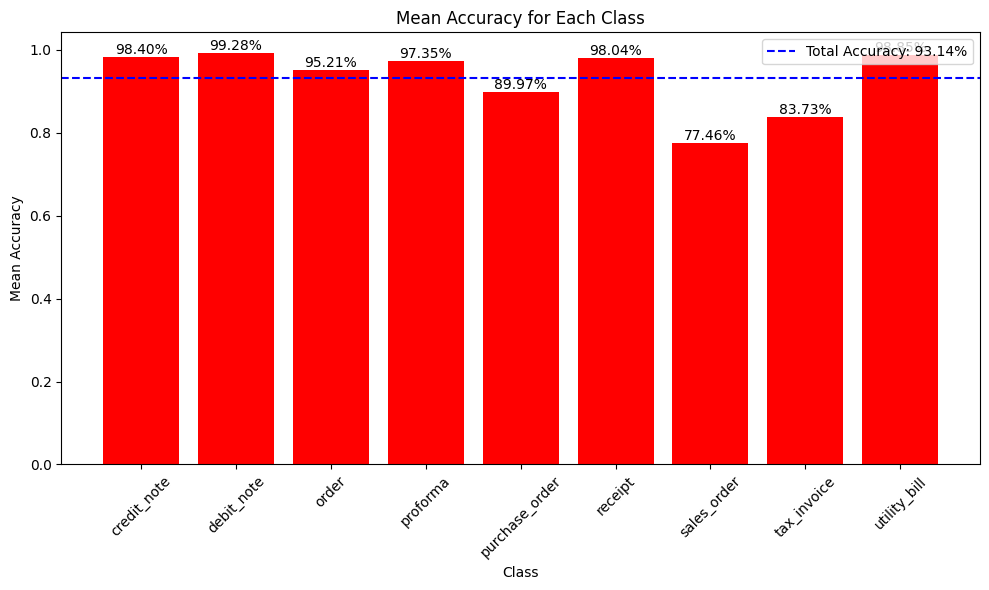

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict



epochs = 10
# Define your predictions and true_labels arrays (assuming they are NumPy arrays)
predictions = np.load("/home/sebastian/Documents/Hauptprojekt/Arrays/DonutInfoExtraction/" + str(epochs) + "epochs_accuracies_all_classes.npy")
true_labels = np.load("/home/sebastian/Documents/Hauptprojekt/Arrays/DonutInfoExtraction/vallabels.npy")

# Create a dictionary to store the mean accuracy and count for each class
class_accuracy = defaultdict(lambda: {'accuracy': 0, 'count': 0})

# Calculate accuracy for each class and count occurrences
for class_name in np.unique(true_labels):
    indices = np.where(true_labels == class_name)
    class_predictions = predictions[indices]
    accuracy = np.mean(class_predictions)
    count = len(class_predictions)
    class_accuracy[class_name]['accuracy'] = accuracy
    class_accuracy[class_name]['count'] = count

total_accuracy = 0

for key, value in class_accuracy.items():
    total_accuracy += value['accuracy'] 
total_accuracy = total_accuracy / 9
    
# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(class_accuracy.keys(), [v['accuracy'] for v in class_accuracy.values()], color='red')
plt.axhline(total_accuracy, color='blue', linestyle='--', label=f'Total Accuracy: {total_accuracy:.2%}')
plt.title('Mean Accuracy for Each Class')
plt.xlabel('Class')
plt.ylabel('Mean Accuracy')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add percentage labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2%}', ha='center', va='bottom')

# Display the plot
plt.legend()
plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/InformationExtraction/Donut' + str(epochs) + 'epochs_accuracies_all_classes.png', bbox_inches='tight')

plt.show()


In [132]:
class_accuracy

defaultdict(<function __main__.<lambda>()>,
            {'credit_note': {'accuracy': 0.9840107875496746, 'count': 2},
             'debit_note': {'accuracy': 0.9928243256595198, 'count': 2},
             'order': {'accuracy': 0.952099459343407, 'count': 53},
             'proforma': {'accuracy': 0.9735331632653061, 'count': 2},
             'purchase_order': {'accuracy': 0.8996901682287233, 'count': 40},
             'receipt': {'accuracy': 0.9804167160789901, 'count': 40},
             'sales_order': {'accuracy': 0.7745726905781452, 'count': 40},
             'tax_invoice': {'accuracy': 0.8373476602225322, 'count': 69},
             'utility_bill': {'accuracy': 0.9885118149824033, 'count': 2}})

In [118]:
file_path = "/home/sebastian/Documents/Hauptprojekt/Arrays/DonutInfoExtraction/model_accuracies_after.pkl"
model_accuracies['10Epochs_all_classes'] = total_accuracy


with open(file_path, 'wb') as file:
    pickle.dump(model_accuracies, file)

print(f"Model accuracy dictionary saved to {file_path}")

Model accuracy dictionary saved to /home/sebastian/Documents/Hauptprojekt/Arrays/DonutInfoExtraction/model_accuracies_after.pkl


In [119]:
model_accuracies

{'10Epochs_random': 0.9307638493605563,
 '7Epochs_random': 0.9266177474698571,
 '7Epochs_3e-5lr': 0.9386014384812208,
 '10Epochs_3e-5lr': 0.9395692965331843,
 '10Epochs_32batch': 0.9432051535877625,
 '7Epochs_32batch': 0.9397216903123718,
 '7Epochs_all_classes': 0.9385186088616992,
 '10Epochs_all_classes': 0.9314451984343002}

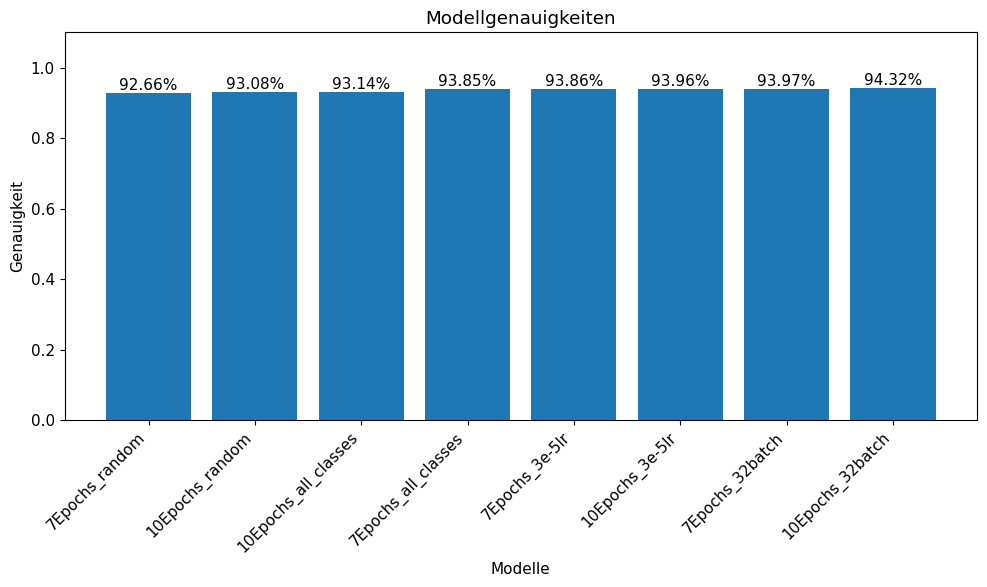

In [1]:
import matplotlib.pyplot as plt
import pickle
import matplotlib
font = {'size': 11}
matplotlib.rc('font', **font)


file_path = "/home/sebastian/Documents/Hauptprojekt/Arrays/DonutInfoExtraction/model_accuracies_after.pkl"
with open(file_path, 'rb') as file:
    data = pickle.load(file)

data = dict(sorted(data.items(), key=lambda item: item[1]))


# Extract the keys (descriptions) and values (accuracy scores) from the dictionary
descriptions = list(data.keys())
accuracies = list(data.values())

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
bars = plt.bar(descriptions, accuracies)
plt.xlabel('Modelle')
plt.ylabel('Genauigkeit')
plt.title('Modellgenauigkeiten')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.ylim(0, 1.1)

# Add accuracy values as text labels above the bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{accuracy:.2%}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/InformationExtraction/DonutModelAccuracies.png', bbox_inches='tight')

plt.show()
